In [1]:
from PIL import Image
import sys
import os
import urllib
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import time
from tf_trt_models.detection import download_detection_model, build_detection_graph

%matplotlib inline

In [2]:
MODEL = 'model'
DATA_DIR = './model_tf/v2/'
CONFIG_FILE = 'pipeline.config'   # ./data/ssd_inception_v2_coco.config 
CHECKPOINT_FILE = 'model.ckpt'    # ./data/ssd_inception_v2_coco/model.ckpt
IMAGE_PATH = 'signals/record/1000.jpg'

In [3]:
#config_path, checkpoint_path = download_detection_model(MODEL, 'data')

In [5]:
frozen_graph, input_names, output_names = build_detection_graph(
    config=DATA_DIR+CONFIG_FILE,
    checkpoint=DATA_DIR+CHECKPOINT_FILE,
    score_threshold=0.3,
    batch_size=1
)

Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


18 ops no flops stats due to incomplete shapes.
18 ops no flops stats due to incomplete shapes.


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model_tf/v2/model.ckpt
INFO:tensorflow:Restoring parameters from ./model_tf/v2/model.ckpt
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 324 variables.
INFO:tensorflow:Converted 324 variables to const ops.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: .generated_model/saved_model/saved_model.pb
INFO:tensorflow:Writing pipeline config file to .generated_model/pipeline.config


In [6]:
print(output_names)
print(input_names)

['detection_boxes', 'detection_classes', 'detection_scores', 'num_detections']
['image_tensor']


In [6]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

INFO:tensorflow:Running against TensorRT version 5.0.6


In [7]:

from tensorflow.python.platform import gfile

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)
with gfile.FastGFile('./model_tf/v2/trt_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf_sess.graph.as_default()
    tf.import_graph_def(graph_def, name='') # 导入计算图
tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

In [7]:
with open('./model_tf/v2/trt_graph.pb', 'wb') as f:
    f.write(trt_graph.SerializeToString())

In [8]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')


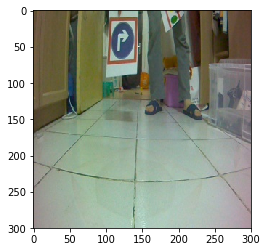

In [8]:
IMAGE_PATH='signals/record/1070.jpg'

image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = np.array(image.resize((300, 300)))
image = np.array(image)

In [9]:
scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_resized[None, ...]
})

boxes = boxes[0] # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = num_detections[0]


1.0
[0.02056175 0.34257275 0.24943587 0.48463172]
7.0
0.65002304


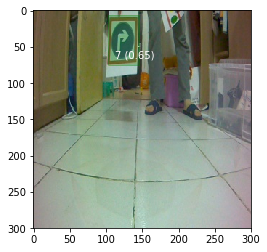

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)
print(num_detections)
num_detections = int(num_detections)
# plot boxes exceeding score threshold
for i in range(num_detections):
    # scale box to image coordinates
    print(boxes[i])
    box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])
    print(classes[i])
    print(scores[i])
    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

plt.show()

In [12]:
num_samples = 50

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

Average runtime: 0.069749 seconds


In [ ]:
tf_sess.close()